### Download the data

In [1]:
!wget https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv

--2022-08-16 20:39:35--  https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5998096 (5.7M) [text/plain]
Saving to: ‘AE_Data.csv’

AE_Data.csv         100%[===================>]   5.72M  --.-KB/s    in 0.09s   

2022-08-16 20:39:36 (60.6 MB/s) - ‘AE_Data.csv’ saved [5998096/5998096]



### Import libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/AE_Data.csv')
df.head()

,title,abstract,label
0,antimicrobial impacts of essential oils on foo...,the antimicrobial activity of twelve essential...,0
1,purification and characterization of a cystein...,antimicrobial peptide (amp) crustin is a type ...,0
2,telavancin activity tested against gram-positi...,objectives: to reassess the activity of telava...,0
3,the in vitro antimicrobial activity of cymbopo...,background: it is well known that cymbopogon (...,0
4,screening currency notes for microbial pathoge...,fomites are a well-known source of microbial i...,0


In [4]:
df['label'].value_counts()

0    3851
1     294
Name: label, dtype: int64

This is unbalanced classification!

### Word Count in Abstract and Title

In [5]:
df['word_count_abstract'] = df['abstract'].str.split().str.len()
df['word_count_title'] = df['title'].str.split().str.len()

print('Min word count in Abstract : ', df['word_count_abstract'].min())
print('Max word count in Abstract : ', df['word_count_abstract'].max())
print('Min word count in Title : ', df['word_count_title'].min())
print('Max word count in Title : ', df['word_count_title'].max())

Min word count in Abstract :  0
Max word count in Abstract :  938
Min word count in Title :  1
Max word count in Title :  35


In [6]:
abstract_bins = range(0,1000,200)

title_bins = range(0,35,7)

# We can use the same iterator for bin and label
df['binned_abstract'] = pd.cut(df['word_count_abstract'], bins=abstract_bins, labels = abstract_bins[1:])
df['binned_title'] = pd.cut(df['word_count_title'], bins=title_bins, labels = title_bins[1:])

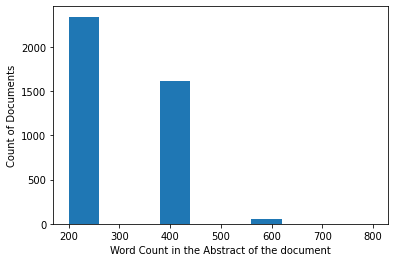

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(df['binned_abstract'], density=False)  # density=False would make counts
plt.ylabel('Count of Documents')
plt.xlabel('Word Count in the Abstract of the document');

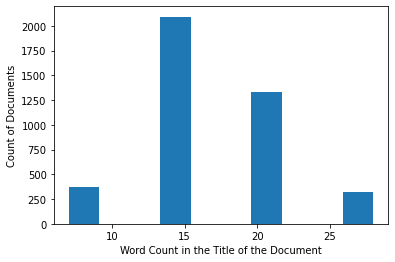

In [8]:
plt.hist(df['binned_title'], density=False)
plt.ylabel('Count of Documents')
plt.xlabel('Word Count in the Title of the Document');

### Positive and Negative Samples

In [9]:
def get_n_samples(input_df, sample_type=1, n=5):
  samples = input_df[input_df['label'] == sample_type][['title', 'abstract']].values[0:n]

  print('*'*80 + f'\nPrinting {n} samples of the type {sample_type}\n' + '*'*80)
  for i in range(n):
    print(f'Title {i} : ', samples[i][0])
    print(f'Abstract {i} : ', samples[i][1])
  print('*'*80)

get_n_samples(df)

********************************************************************************
Printing 5 samples of the type 1
********************************************************************************
Title 0 :  probiotic features of lactobacillus strains isolated from ragusano and pecorino siciliano cheeses.

Abstract 0 :  in the present study 177 lactobacillus spp. strains, isolated from ragusano and pecorino siciliano cheeses, were in vitro screened for probiotic traits, and their characteristics were compared to those ofother_species gg, commercial strain. based on acidic and bile salt resistance, thirteen lactobacillus strains were selected. the multiplex-pcr application revealed that  nine strains belonged toother_species species and four toother_species species. all selected strains were further investigated for transit tolerance in  simulated upper gastrointestinal tract (gi), for adhesion capacity to human intestinal cell lines, for hydrophobicity, for co-aggregation and auto-aggreg

In [10]:
get_n_samples(df,0)

********************************************************************************
Printing 5 samples of the type 0
********************************************************************************
Title 0 :  antimicrobial impacts of essential oils on food borne-pathogens.

Abstract 0 :  the antimicrobial activity of twelve essential oil (pine oil, eucalyptus, thyme,  sage tea, lavender, orange, laurel, lemon, myrtle, lemon, rosemary and juniper) was tested by a disc diffusion method against food borne pathogens (escherichia coli,other_species a,other_species,other_species,other_species,other_species,other_species, enterococcus  faecalis,other_species). the major components in essential oils were monoterpenes hydrocarbons, alpha-pinene, limonene; monoterpene phenol, carvacrol  and oxygenated monoterpenes, camphor, 1,8-cineole, eucalyptol, linalool and linalyl acetate. although the antimicrobial effect of essential oils varied depending on the chemical composition of the essential oils and

### Token Analysis

Let's understand the tokens per record in the abstract and title

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
import requests
import tensorflow as tf
import tensorflow_text as tf_text

In [17]:
# First, need to download BERT vocab file, basically a list of acceptable tokens

url = "https://github.com/tensorflow/text/blob/master/tensorflow_text/python/ops/test_data/test_wp_en_vocab.txt?raw=true"
r = requests.get(url)
filepath = "vocab.txt"
open(filepath, 'wb').write(r.content)

52382

In [18]:
# Initialize the tokens, let's see on an example
tokenizer = tf_text.BertTokenizer(filepath, token_out_type=tf.string, lower_case=True)
tokens = tokenizer.tokenize(["What you know you can't explain, but you feel it."])
print(tokens.to_list())

[[[b'what'], [b'you'], [b'know'], [b'you'], [b'can'], [b"'"], [b't'], [b'explain'], [b','], [b'but'], [b'you'], [b'feel'], [b'it'], [b'.']]]


In [34]:
def get_token_len(x):
  return len(tokenizer.tokenize([x]).to_list()[0])

df['abstract_token_len'] = df['abstract'].apply(lambda x : get_token_len(x))
df['title_token_len'] = df['title'].apply(lambda x : get_token_len(x))

In [35]:
print('Min Token count in Abstract : ', df['abstract_token_len'].min())
print('Max Token count in Abstract : ', df['abstract_token_len'].max())
print('Min Token count in Title : ', df['title_token_len'].min())
print('Max Token count in Title : ', df['title_token_len'].max())

Min Token count in Abstract :  0
Max Token count in Abstract :  1168
Min Token count in Title :  1
Max Token count in Title :  71


Whoa! 0 useful tokens. Need to drop those records in data cleaning

In [38]:
abstract_bins = range(0,1200,200)

title_bins = range(0,70,10)

# We can use the same iterator for bin and label
df['binned_abstract_tokens'] = pd.cut(df['abstract_token_len'], bins=abstract_bins, labels = abstract_bins[1:])
df['binned_title_tokens'] = pd.cut(df['title_token_len'], bins=title_bins, labels = title_bins[1:])

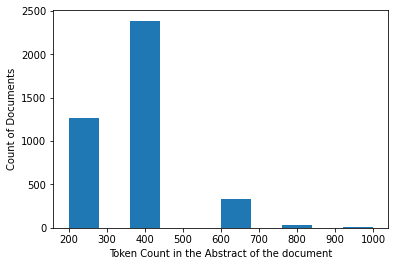

In [39]:
plt.hist(df['binned_abstract_tokens'], density=False)
plt.ylabel('Count of Documents')
plt.xlabel('Token Count in the Abstract of the document');

Majority Abstracts have token count < 500. This works well with BERT token limitation of 512 tokens

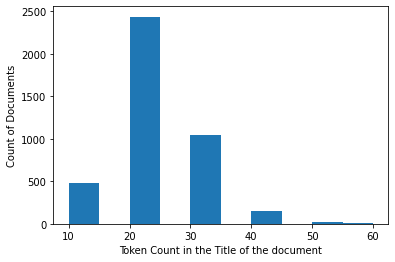

In [40]:
plt.hist(df['binned_title_tokens'], density=False)
plt.ylabel('Count of Documents')
plt.xlabel('Token Count in the Title of the document');